# SVR model to predict instagram likes out of sentiment concepts in the pictures

In this notebook we are going to try to predict the number of likes a Instagram post containing the hashtag #burgerking or #mcdonalds will have.

For this, we are going to evaluate 4 different models (SVR, GBR and Lasso regression + Elastic-net) for 5 different groups of features named:  

**F1:** *"Visual sentiment"*  
1200 text sentiment descriptors about the picture

**F2:** *"Previous activity"*  
Previous posted media by the user + length of bio + number of users the user follows

**F3:** *"Caption completition"*  
Sentiment of caption + Number of hashtags

**F4:** *"Number of followers"*

## Data preparation

Load modules

In [14]:
import csv
import pandas as pd
import numpy as np
import matplotlib
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from collections import Counter
from sklearn.svm import SVR
import time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm 
# http://www2.warwick.ac.uk/fac/sci/moac/people/students/peter_cock/python/rank_correlations/
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html
# R^2 vs Pearson correlation: http://mathbits.com/MathBits/TISection/Statistics2/correlation.htm
import scipy.stats # spearmanr 
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import operator
from sklearn import linear_model
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix # classification evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score # regression evaluation

Plot configuration

In [15]:
matplotlib.style.use('ggplot')
%matplotlib inline 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.max_colwidth = 200
pd.set_option('display.width', 1000)

Load the data and clean it (first column is not correctly formated)

In [16]:
D_DIR = "../data/"
bk_sentiname = "burgerking/BK_sentiName.txt"
bk_sentiment = "burgerking/BK_Sentiment.txt"

bk_sentiname = pd.read_csv(D_DIR + bk_sentiname) # dump csv into a Pandas DataFrame

column_names = map(lambda x: x.strip(" "), list(bk_sentiname.columns.ravel()))
column_names.insert(0, "instaGramId")

bk_sentiment = pd.read_csv(D_DIR + bk_sentiment, names=column_names ) # dump csv into a Pandas DataFrame

In [7]:
bk_sentiment.head(2)

,instaGramId,cloudy_moon,super_moon,misty_woods,cloudy_mountains,misty_field,cloudy_landscape,misty_road,tiny_bathroom,stunning_sunset,cloudy_valley,awesome_clouds,empty_train,misty_sunrise,rough_waves,classic_cars,bright_moon,tiny_mushrooms,powerful_waves,misty_night,lovely_clouds,cloudy_sunrise,crazy_clouds,calm_lake,bright_angel,rough_coast,golden_sunrise,clear_night,calm_ocean,lonely_boat,amazing_armory,cloudy_night,sunny_flowers,misty_trees,incredible_sunset,colorful_sky,super_cars,beautiful_rose,beautiful_butterfly,amazing_sunset,empty_office,clean_baby,great_sunset,sunny_trees,calm_beach,tiny_car,cloudy_view,gentle_river,ugly_building,curious_deer,quiet_study,rough_sketch,empty_desk,magical_sunset,beautiful_sunset,clear_sea,stormy_mountain,wet_grass,awesome_sunset,amazing_clouds,clear_moon,nice_beach,crowded_beach,stunning_clouds,magnificent_clouds,misty_morning,stormy_field,awesome_cars,misty_forest,peaceful_lake,cloudy_evening,cloudy_lake,empty_market,rainy_windows,incredible_sunrise,colorful_sunset,dark_street,wild_flowers,shiny_cars,tiny_fly,magnificent_mountain,incredible_beach,expensive_car,shiny_toy,clear_beach,young_pony,colorful_clouds,colorful_flowers,beautiful_clouds,great_ocean,stormy_clouds,prickly_heart,dead_fly,magnificent_church,lovely_beach,misty_autumn,stunning_waterfall,misty_lake,charming_house,bright_sunset,beautiful_sky,silly_face,clear_river,ugly_fish,wet_leaves,empty_street,smooth_waterfall,famous_church,empty_theatre,empty_airport,damaged_car,strange_clouds,colorful_street,icy_grass,ugly_drawing,warm_chocolate,nice_street,colorful_building,dark_tree,crowded_street,dirty_car,famous_lighthouse,tranquil_pond,empty_room,powerful_waterfall,sexy_halloween,expensive_house,young_deer,dry_landscape,misty_valley,nice_clouds,magnificent_sky,lost_lake,dry_field,ancient_bridge,clean_car,weird_building,dry_lake,icy_lake,golden_sunset,sleepy_cat,rainy_night,tiny_spider,ugly_car,fresh_leaves,icy_river,cloudy_city,funny_sign,great_sky,calm_sea,weird_bug,scenic_mountain,stormy_waves,tiny_bug,quiet_lake,wild_deer,magical_sky,rotten_tree,fantastic_car,ancient_trees,classic_sports,misty_winter,traditional_fishing,smooth_sand,dry_forest,nice_building,quiet_pond,empty_field,amazing_architecture,fantastic_beach,sunny_field,amazing_sky,natural_hair,golden_autumn,tiny_insect,smooth_waves,clear_ocean,heavy_clouds,quiet_park,colorful_autumn,misty_hills,calm_river,stormy_landscape,abandoned_hospitals,weird_clouds,cute_puppy,sleepy_puppy,wild_flora,pretty_sky,damaged_building,classic_commercial,comfortable_room,tranquil_lake,charming_street,smooth_clouds,beautiful_beach,wild_grass,peaceful_creek,fluffy_plant,colorful_trees,empty_bathroom,gentle_waves,creepy_forest,busy_river,clear_mountain,fantastic_flowers,incredible_sky,clear_pool,calm_waves,classic_rally,smooth_sea,wild_mushrooms,famous_building,busy_street,dry_island,fluffy_snow,magnificent_view,muddy_legs,tiny_hands,weird_plant,busy_city,calm_sky,quiet_creek,colorful_leaves,tired_dad,lonely_island,hot_car,classic_architecture,cloudy_morning,wet_cat,beautiful_flower,broken_window,expensive_boat,magical_forest,hot_pool,empty_building,traditional_tattoo,fantastic_architecture,dangerous_road,weird_tree,fluffy_clouds,dark_forest,creepy_tree,crazy_crowd,rainy_market,fantastic_sunrise,smiling_baby,young_tree,funny_baby,fancy_car,...,hot_model,outdoor_concert,amazing_city,tired_girls,funny_wedding,hungry_zombie,dead_bug,pretty_shoes,excited_student,handsome_face,wild_bird,sexy_smile,silly_cat,dusty_mirror,wary_birds,sweet_princess,happy_cats,dark_night,delicious_apple,scary_face,scared_dog,tasty_food,charming_places,elegant_bird,cuddly_puppy,classic_coke,gorgeous_scene,beautiful_girl,smiling_girls,shy_cat,ancient_farm,sexy_chest,nice_cup,beautiful_city,amazing_hair,dead_fish,evil_skull,excellent_architecture,powerful_river,wild_animals,rotten_apple,amazing_race,stupid_cat,outdoor_performance,pretty_dress,sad_cat,christian_wedding,hot_food,clear_lake,great_street,haunted_attract

In [8]:
bk_sentiment.shape

(22073, 1201)

In [17]:
nn = bk_sentiment.columns.ravel()
for a in nn:
    print a

instaGramId
cloudy_moon
super_moon
misty_woods
cloudy_mountains
misty_field
cloudy_landscape
misty_road
tiny_bathroom
stunning_sunset
cloudy_valley
awesome_clouds
empty_train
misty_sunrise
rough_waves
classic_cars
bright_moon
tiny_mushrooms
powerful_waves
misty_night
lovely_clouds
cloudy_sunrise
crazy_clouds
calm_lake
bright_angel
rough_coast
golden_sunrise
clear_night
calm_ocean
lonely_boat
amazing_armory
cloudy_night
sunny_flowers
misty_trees
incredible_sunset
colorful_sky
super_cars
beautiful_rose
beautiful_butterfly
amazing_sunset
empty_office
clean_baby
great_sunset
sunny_trees
calm_beach
tiny_car
cloudy_view
gentle_river
ugly_building
curious_deer
quiet_study
rough_sketch
empty_desk
magical_sunset
beautiful_sunset
clear_sea
stormy_mountain
wet_grass
awesome_sunset
amazing_clouds
clear_moon
nice_beach
crowded_beach
stunning_clouds
magnificent_clouds
misty_morning
stormy_field
awesome_cars
misty_forest
peaceful_lake
cloudy_evening
cloudy_lake
empty_market
rainy_windows
incredible_s

In [18]:
bk_sentiment.insert(1, "i1", "")
bk_sentiment["i1"] = bk_sentiment["instaGramId"].apply(lambda x : x.split(":")[1])
bk_sentiment["instaGramId"] = bk_sentiment["instaGramId"].apply(lambda x : x.split(":")[0])
bk_sentiment.head(2)

,instaGramId,i1,cloudy_moon,super_moon,misty_woods,cloudy_mountains,misty_field,cloudy_landscape,misty_road,tiny_bathroom,stunning_sunset,cloudy_valley,awesome_clouds,empty_train,misty_sunrise,rough_waves,classic_cars,bright_moon,tiny_mushrooms,powerful_waves,misty_night,lovely_clouds,cloudy_sunrise,crazy_clouds,calm_lake,bright_angel,rough_coast,golden_sunrise,clear_night,calm_ocean,lonely_boat,amazing_armory,cloudy_night,sunny_flowers,misty_trees,incredible_sunset,colorful_sky,super_cars,beautiful_rose,beautiful_butterfly,amazing_sunset,empty_office,clean_baby,great_sunset,sunny_trees,calm_beach,tiny_car,cloudy_view,gentle_river,ugly_building,curious_deer,quiet_study,rough_sketch,empty_desk,magical_sunset,beautiful_sunset,clear_sea,stormy_mountain,wet_grass,awesome_sunset,amazing_clouds,clear_moon,nice_beach,crowded_beach,stunning_clouds,magnificent_clouds,misty_morning,stormy_field,awesome_cars,misty_forest,peaceful_lake,cloudy_evening,cloudy_lake,empty_market,rainy_windows,incredible_sunrise,colorful_sunset,dark_street,wild_flowers,shiny_cars,tiny_fly,magnificent_mountain,incredible_beach,expensive_car,shiny_toy,clear_beach,young_pony,colorful_clouds,colorful_flowers,beautiful_clouds,great_ocean,stormy_clouds,prickly_heart,dead_fly,magnificent_church,lovely_beach,misty_autumn,stunning_waterfall,misty_lake,charming_house,bright_sunset,beautiful_sky,silly_face,clear_river,ugly_fish,wet_leaves,empty_street,smooth_waterfall,famous_church,empty_theatre,empty_airport,damaged_car,strange_clouds,colorful_street,icy_grass,ugly_drawing,warm_chocolate,nice_street,colorful_building,dark_tree,crowded_street,dirty_car,famous_lighthouse,tranquil_pond,empty_room,powerful_waterfall,sexy_halloween,expensive_house,young_deer,dry_landscape,misty_valley,nice_clouds,magnificent_sky,lost_lake,dry_field,ancient_bridge,clean_car,weird_building,dry_lake,icy_lake,golden_sunset,sleepy_cat,rainy_night,tiny_spider,ugly_car,fresh_leaves,icy_river,cloudy_city,funny_sign,great_sky,calm_sea,weird_bug,scenic_mountain,stormy_waves,tiny_bug,quiet_lake,wild_deer,magical_sky,rotten_tree,fantastic_car,ancient_trees,classic_sports,misty_winter,traditional_fishing,smooth_sand,dry_forest,nice_building,quiet_pond,empty_field,amazing_architecture,fantastic_beach,sunny_field,amazing_sky,natural_hair,golden_autumn,tiny_insect,smooth_waves,clear_ocean,heavy_clouds,quiet_park,colorful_autumn,misty_hills,calm_river,stormy_landscape,abandoned_hospitals,weird_clouds,cute_puppy,sleepy_puppy,wild_flora,pretty_sky,damaged_building,classic_commercial,comfortable_room,tranquil_lake,charming_street,smooth_clouds,beautiful_beach,wild_grass,peaceful_creek,fluffy_plant,colorful_trees,empty_bathroom,gentle_waves,creepy_forest,busy_river,clear_mountain,fantastic_flowers,incredible_sky,clear_pool,calm_waves,classic_rally,smooth_sea,wild_mushrooms,famous_building,busy_street,dry_island,fluffy_snow,magnificent_view,muddy_legs,tiny_hands,weird_plant,busy_city,calm_sky,quiet_creek,colorful_leaves,tired_dad,lonely_island,hot_car,classic_architecture,cloudy_morning,wet_cat,beautiful_flower,broken_window,expensive_boat,magical_forest,hot_pool,empty_building,traditional_tattoo,fantastic_architecture,dangerous_road,weird_tree,fluffy_clouds,dark_forest,creepy_tree,crazy_crowd,rainy_market,fantastic_sunrise,smiling_baby,young_tree,funny_baby,...,hot_model,outdoor_concert,amazing_city,tired_girls,funny_wedding,hungry_zombie,dead_bug,pretty_shoes,excited_student,handsome_face,wild_bird,sexy_smile,silly_cat,dusty_mirror,wary_birds,sweet_princess,happy_cats,dark_night,delicious_apple,scary_face,scared_dog,tasty_food,charming_places,elegant_bird,cuddly_puppy,classic_coke,gorgeous_scene,beautiful_girl,smiling_girls,shy_cat,ancient_farm,sexy_chest,nice_cup,beautiful_city,amazing_hair,dead_fish,evil_skull,excellent_architecture,powerful_river,wild_animals,rotten_apple,amazing_race,stupid_cat,outdoor_performance,pretty_dress,sad_cat,christian_wedding,hot_food,clear_lake,great_street,haunted_attraction,you

In [19]:
old_names = list(bk_sentiment.columns.ravel())
old_names = map(lambda x: x.strip(" "), old_names)
rename_dict = {old_name: column_name for (old_name, column_name) in zip(old_names, column_names)}
bk_sentiment.rename(columns = rename_dict, inplace=True)

Remove last column without mentioning its name as it is duplicated

In [20]:
bk_sentiment = bk_sentiment.iloc[:,:-1]

In [13]:
bk_sentiment.head(3)

,instaGramId,cloudy_moon,super_moon,misty_woods,cloudy_mountains,misty_field,cloudy_landscape,misty_road,tiny_bathroom,stunning_sunset,cloudy_valley,awesome_clouds,empty_train,misty_sunrise,rough_waves,classic_cars,bright_moon,tiny_mushrooms,powerful_waves,misty_night,lovely_clouds,cloudy_sunrise,crazy_clouds,calm_lake,bright_angel,rough_coast,golden_sunrise,clear_night,calm_ocean,lonely_boat,amazing_armory,cloudy_night,sunny_flowers,misty_trees,incredible_sunset,colorful_sky,super_cars,beautiful_rose,beautiful_butterfly,amazing_sunset,empty_office,clean_baby,great_sunset,sunny_trees,calm_beach,tiny_car,cloudy_view,gentle_river,ugly_building,curious_deer,quiet_study,rough_sketch,empty_desk,magical_sunset,beautiful_sunset,clear_sea,stormy_mountain,wet_grass,awesome_sunset,amazing_clouds,clear_moon,nice_beach,crowded_beach,stunning_clouds,magnificent_clouds,misty_morning,stormy_field,awesome_cars,misty_forest,peaceful_lake,cloudy_evening,cloudy_lake,empty_market,rainy_windows,incredible_sunrise,colorful_sunset,dark_street,wild_flowers,shiny_cars,tiny_fly,magnificent_mountain,incredible_beach,expensive_car,shiny_toy,clear_beach,young_pony,colorful_clouds,colorful_flowers,beautiful_clouds,great_ocean,stormy_clouds,prickly_heart,dead_fly,magnificent_church,lovely_beach,misty_autumn,stunning_waterfall,misty_lake,charming_house,bright_sunset,beautiful_sky,silly_face,clear_river,ugly_fish,wet_leaves,empty_street,smooth_waterfall,famous_church,empty_theatre,empty_airport,damaged_car,strange_clouds,colorful_street,icy_grass,ugly_drawing,warm_chocolate,nice_street,colorful_building,dark_tree,crowded_street,dirty_car,famous_lighthouse,tranquil_pond,empty_room,powerful_waterfall,sexy_halloween,expensive_house,young_deer,dry_landscape,misty_valley,nice_clouds,magnificent_sky,lost_lake,dry_field,ancient_bridge,clean_car,weird_building,dry_lake,icy_lake,golden_sunset,sleepy_cat,rainy_night,tiny_spider,ugly_car,fresh_leaves,icy_river,cloudy_city,funny_sign,great_sky,calm_sea,weird_bug,scenic_mountain,stormy_waves,tiny_bug,quiet_lake,wild_deer,magical_sky,rotten_tree,fantastic_car,ancient_trees,classic_sports,misty_winter,traditional_fishing,smooth_sand,dry_forest,nice_building,quiet_pond,empty_field,amazing_architecture,fantastic_beach,sunny_field,amazing_sky,natural_hair,golden_autumn,tiny_insect,smooth_waves,clear_ocean,heavy_clouds,quiet_park,colorful_autumn,misty_hills,calm_river,stormy_landscape,abandoned_hospitals,weird_clouds,cute_puppy,sleepy_puppy,wild_flora,pretty_sky,damaged_building,classic_commercial,comfortable_room,tranquil_lake,charming_street,smooth_clouds,beautiful_beach,wild_grass,peaceful_creek,fluffy_plant,colorful_trees,empty_bathroom,gentle_waves,creepy_forest,busy_river,clear_mountain,fantastic_flowers,incredible_sky,clear_pool,calm_waves,classic_rally,smooth_sea,wild_mushrooms,famous_building,busy_street,dry_island,fluffy_snow,magnificent_view,muddy_legs,tiny_hands,weird_plant,busy_city,calm_sky,quiet_creek,colorful_leaves,tired_dad,lonely_island,hot_car,classic_architecture,cloudy_morning,wet_cat,beautiful_flower,broken_window,expensive_boat,magical_forest,hot_pool,empty_building,traditional_tattoo,fantastic_architecture,dangerous_road,weird_tree,fluffy_clouds,dark_forest,creepy_tree,crazy_crowd,rainy_market,fantastic_sunrise,smiling_baby,young_tree,funny_baby,fancy_car,...,hot_model,outdoor_concert,amazing_city,tired_girls,funny_wedding,hungry_zombie,dead_bug,pretty_shoes,excited_student,handsome_face,wild_bird,sexy_smile,silly_cat,dusty_mirror,wary_birds,sweet_princess,happy_cats,dark_night,delicious_apple,scary_face,scared_dog,tasty_food,charming_places,elegant_bird,cuddly_puppy,classic_coke,gorgeous_scene,beautiful_girl,smiling_girls,shy_cat,ancient_farm,sexy_chest,nice_cup,beautiful_city,amazing_hair,dead_fish,evil_skull,excellent_architecture,powerful_river,wild_animals,rotten_apple,amazing_race,stupid_cat,outdoor_performance,pretty_dress,sad_cat,christian_wedding,hot_food,clear_lake,great_street,haunted_attract

In [14]:
bk_sentiment.shape

(22073, 1201)

In [21]:
D_DIR = "../data/"
mcdonalds_icmr_clean = "mcdonalds/df_mc_20161011.pkl"
burgerking_icmr_clean = "burgerking/df_bk_20161011.pkl"
df_mc_ = pd.read_pickle(D_DIR + mcdonalds_icmr_clean) # dump csv into a Pandas DataFrame
df_bk_ = pd.read_pickle(D_DIR + burgerking_icmr_clean) # dump csv into a Pandas DataFrame

In [8]:
df_bk_[df_bk_["instaGramId"].str.contains("1154326235355936985_421894989")]

,instaGramId,imageDateCreated,imageTagCount,imageFilter,imageLikeCount,imageCommentCount,imageLink,imageCaption,imageUsersInImageCollection,imageTagCollection,imageLongitude,imageLatitude,userFullName,userProfileImage,userName,userId,followedByCount,followersCount,postedMedia,userBio,userPostedLikedImage,comments,googleLogo,googleFaceCount,googleText,googleLandMark,product,brand,googleLabel_list,googleLabelConfidence_list,googleLabel_dict,imageTagCollection_list,imageCaption_clean,famous_attribute,activity_attribute,sentiment_attribute_num,sentiment_attribute,imageDateCreated_str,weekend_attribute,filter_attribute,face_attribute,logo_attribute,food_attribute,conjoint_category
2249,1154326235355936985_421894989,1451826432,1,Amaro,3,0,https://scontent.cdninstagram.com/hphotos-xpf1/t51.2885-15/s640x640/sh0.08/e35/917557_1168329436530587_2070734503_n.jpg,#burgerking,[],"[""burgerking""]",37.575524,55.759627,Muhammad_248,https://scontent.cdninstagram.com/hphotos-xat1/t51.2885-19/s150x150/1170061_1684599801824801_935863285_a.jpg,muhammad_248,421894989,13,31,16,NaN,False,[],[],1,"""ise)""",NaN,0,BurgerKing,"[painting, person, writing, human positions]","[0.74878728, 0.85403252, 0.60658258, 0.92704481]","{u'person': 0.85403252, u'human positions': 0.92704481, u'painting': 0.74878728, u'writing': 0.60658258}",[burgerking],[],common,high,0,neutral,2016-01-03 13:07:12,weekend yes,filter yes,face yes,logo no,food no,0


In [15]:
df_bk_sentiment = pd.merge(df_bk_[["instaGramId", "imageLikeCount"]], bk_sentiment, how='inner', on="instaGramId")

Function for fitting and evaluation of models in a sistematic wey

In [81]:
def eval_model(df, column_names, gbr_est_param):
    train, test = train_test_split(df[column_names], train_size = 0.5)
    if "instaGramId" in train.columns:
        train.set_index("instaGramId", inplace=True)
    if "instaGramId" in test.columns:
        test.set_index("instaGramId", inplace=True)
    if "instaGramId" in column_names:
        column_names.remove("instaGramId")
    X_train = train.drop("imageLikeCount", 1)
    y_train = train["imageLikeCount"]
    X_test = test.drop("imageLikeCount", 1)
    y_test = test["imageLikeCount"]
    start = time.time()
    est = gbr_est_param.fit(X_train, y_train)
    print("Fitting of the model took", str(float(time.time() - start)), "seconds")
    if type(gbr_est_param) == GradientBoostingRegressor:
        feature_importances_dict = {train_column_name: feature_importance for (train_column_name,
                                                                               feature_importance) in zip(column_names, est.feature_importances_)}
        top10_feature_importances = sorted(feature_importances_dict.items(), key=operator.itemgetter(1), reverse=True)[:10]
        print("Distribution of importances of variables, sum is 1:")
        print(top10_feature_importances)
    y_pred = est.predict(X_test)
    print("Mean absolute error is: %.2f\t" % mean_absolute_error(y_test, y_pred))
    print("Mean squared error is: %.2f\t" % mean_squared_error(y_test, y_pred))
    print("Median absolute error is: %.2f\t" % median_absolute_error(y_test, y_pred))
    print("R^2 score:\t%.4f\t" % r2_score(y_test, y_pred))
    print(zip(list(y_test.iloc[0:15]), list(y_pred[0:15])))
    # linear only, does NOT assume that both datasets are normally distributed.
    print("Pearson correlation (correlation, p-value):", scipy.stats.spearmanr(y_test, y_pred))
    # linear only, does assume that both datasets are normally distributed.
    print("Spearman rank-order (correlation, p-value):", scipy.stats.pearsonr(y_test, y_pred))
    

## F1: Visual sentiment

Exhaustive search over specified parameter values for an estimator using GridSearchCV

In [17]:
msk = np.random.rand(len(df_bk_sentiment)) < 0.5
train = df_bk_sentiment[msk]
#train.set_index("instaGramId", inplace=True)
test = df_bk_sentiment[~msk]
#test.set_index("instaGramId", inplace=True)

train_column_names = list(train.columns.ravel())
#train_column_names.remove("imageLikeCount")

### Gradient Boosting Regressor

In [25]:
tuned_parameters3 = [{'n_estimators': [50, 100, 200], 'max_depth': [3], 'learning_rate': [1e-2]},
                   ]

grid3 = GridSearchCV(estimator=GradientBoostingRegressor(verbose=True), param_grid=tuned_parameters3)
grid3 = grid3.fit(train.drop("imageLikeCount", 1), train["imageLikeCount"])

      Iter       Train Loss   Remaining Time 
         1       24584.9123           51.94s
         2       24436.0076           50.52s
         3       24290.0660           48.96s
         4       24147.0287           47.77s
         5       24006.8378           46.74s
         6       23869.4367           45.51s
         7       23734.7518           44.36s
         8       23602.6903           43.31s
         9       23473.2391           42.20s
        10       23346.3083           41.20s
        20       22206.2156           31.42s
        30       21270.5744           20.85s
        40       20501.6122           10.44s
        50       19868.8228            0.00s
      Iter       Train Loss   Remaining Time 
         1       18267.9185           50.47s
         2       18045.5890           49.44s
         3       17827.6839           49.29s
         4       17614.1151           48.38s
         5       17404.7785           48.09s
         6       17199.5881           47.07s
        

In [28]:
grid3.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}

In [29]:
tuned_parameters4 = [{'n_estimators': [50, 20, 10], 'max_depth': [1, 2, 3], 'learning_rate': [1e-2]},
                   ]

grid4 = GridSearchCV(estimator=GradientBoostingRegressor(verbose=True), param_grid=tuned_parameters4)
grid4 = grid4.fit(train.drop("imageLikeCount", 1), train["imageLikeCount"])

      Iter       Train Loss   Remaining Time 
         1       24621.5954           32.93s
         2       24508.6437           31.97s
         3       24397.9397           32.15s
         4       24289.4387           31.33s
         5       24183.0970           30.46s
         6       24078.8714           29.58s
         7       23976.7199           28.91s
         8       23876.6012           28.16s
         9       23778.4749           27.60s
        10       23682.3013           27.27s
        20       22819.7864           20.17s
        30       22114.3294           13.54s
        40       21537.2117            6.83s
        50       21062.2163            0.00s
      Iter       Train Loss   Remaining Time 
         1       18270.1230           40.13s
         2       18049.9541           37.78s
         3       17834.1666           36.14s
         4       17622.6733           35.97s
         5       17415.3887           34.83s
         6       17212.2291           33.81s
        

In [30]:
grid4.best_params_

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}

In [35]:
tuned_parameters5 = [{'n_estimators': [5, 2, 10], 'max_depth': [1, 2, 3], 'learning_rate': [1e-2]},
                    #{'n_estimators': [400], 'max_depth': [3,5], 'learning_rate': [1e-2]},
                   ]

grid5 = GridSearchCV(estimator=GradientBoostingRegressor(verbose=True), param_grid=tuned_parameters5)
grid5 = grid5.fit(train.drop("imageLikeCount", 1), train["imageLikeCount"])

      Iter       Train Loss   Remaining Time 
         1       24720.7308            1.31s
         2       24704.9417            0.98s
         3       24689.4669            0.65s
         4       24674.3000            0.33s
         5       24659.2441            0.00s
      Iter       Train Loss   Remaining Time 
         1       18491.8532            1.32s
         2       18489.0022            0.97s
         3       18486.2079            0.64s
         4       18483.4692            0.32s
         5       18480.7531            0.00s
      Iter       Train Loss   Remaining Time 
         1       13634.4702            1.39s
         2       13593.9337            1.00s
         3       13554.2038            0.66s
         4       13515.2646            0.33s
         5       13477.1002            0.00s
      Iter       Train Loss   Remaining Time 
         1       24720.7308            0.34s
         2       24704.9417            0.00s
      Iter       Train Loss   Remaining Time 
     

In [36]:
grid5.best_params_

{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 2}

Strange result, too few estimators... Let's test it

In [36]:
# best params found {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 2}
train_column_names = list(train.columns.ravel())
est = GradientBoostingRegressor(n_estimators=2, learning_rate=0.01, max_depth=1)
eval_model(df_bk_sentiment, train_column_names, est)

('Fitting of the model took', '5.30800008774', 'seconds')
Distribution of importances of variables, sum is 1:
[('creepy_eyes', 1.0), ('dry_leaves', 0.0), ('tiny_dog', 0.0), ('golden_flower', 0.0), ('jolly_santa', 0.0), ('crying_girls', 0.0), ('cloudy_landscape', 0.0), ('quiet_park', 0.0), ('stormy_landscape', 0.0), ('peaceful_sleep', 0.0)]
Mean absolute error is: 32.28	
Mean squared error is: 10601.54	
Median absolute error is: 23.10	
R^2 score:	-0.0001	
[(181, 37.100363825835792), (23, 37.100363825835792), (8, 37.100363825835792), (8, 37.100363825835792), (16, 37.100363825835792), (8, 37.100363825835792), (28, 37.100363825835792), (32, 37.100363825835792), (3, 37.100363825835792), (32, 37.100363825835792), (12, 37.100363825835792), (25, 37.100363825835792), (16, 37.100363825835792), (36, 37.100363825835792), (4, 37.100363825835792)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.0044538782253471356, pvalue=0.63988401211245105))
('Spearman rank-order (cor

### SVR (Epsilon-Support Vector Regression)

In [17]:
tuned_parameters6 = [{'kernel': ['rbf'], 'C': [1e1, 1e2], 'gamma': [1e-1, 1e-2]},
                   ]

grid6 = GridSearchCV(estimator=SVR(verbose=True), param_grid=tuned_parameters6, n_jobs=-1)
grid6 = grid6.fit(train.drop("imageLikeCount", 1), train["imageLikeCount"])

[LibSVM]

In [18]:
grid6.best_params_

{'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}

In [19]:
train_column_names = list(train.columns.ravel())
est = SVR(C=100, gamma="auto", kernel="rbf")
eval_model(df_bk_sentiment, train_column_names, est)

('Fitting of the model took', '278.179999828', 'seconds')
Mean absolute error is: 26.60	
Mean squared error is: 17734.40	
Median absolute error is: 10.78	
R^2 score:	-0.0141	
[(12, 19.502441765390365), (9, 22.364992328598753), (40, 27.354090523121634), (1, 18.236636776950256), (9, 24.596829010186646), (47, 19.377035912185953), (2, 16.742513902979958), (44, 24.08193515672891), (10, 24.865321642234484), (12, 22.356692552183681), (11, 19.329599630718086), (19, 16.512780145027286), (12, 21.306271892567601), (18, 23.440022394385927), (7, 18.800106001068777)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.22028284351977043, pvalue=2.2157943274475782e-121))
('Spearman rank-order (correlation, p-value):', (0.058335058044621968, 8.6214170030308415e-10))


In [22]:
train_column_names = list(train.columns.ravel())
est = SVR(C=100, gamma=0.1, kernel="rbf")
eval_model(df_bk_sentiment, train_column_names, est)

('Fitting of the model took', '1641.97300005', 'seconds')
Mean absolute error is: 28.64	
Mean squared error is: 13501.24	
Median absolute error is: 15.85	
R^2 score:	0.0001	
[(8, 34.147562486534632), (248, 17.477511995922406), (25, 27.040908832269849), (51, 41.319217808454042), (27, 22.120106240046052), (18, 39.236688338374442), (0, 26.71141875691173), (34, 25.445593526932903), (5, 29.587102053818093), (13, 26.893619613978935), (40, 35.606764184374335), (29, 39.611699002262043), (18, 25.128786141554709), (3, 45.130113219076037), (44, 61.711687568753582)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.17702453558950368, pvalue=2.1754038916758669e-78))
('Spearman rank-order (correlation, p-value):', (0.072737678964879829, 1.9960606425610362e-14))


### Lasso (Linear Model trained with L1 prior as regularizer)

In [27]:
train_column_names = list(train.columns.ravel())
reg = linear_model.Lasso(alpha = 0.1)
eval_model(df_bk_sentiment, train_column_names, reg)

('Fitting of the model took', '25.3209998608', 'seconds')
Mean absolute error is: 33.36	
Mean squared error is: 6881.38	
Median absolute error is: 22.23	
R^2 score:	-0.0163	
[(4, 37.501810204727398), (45, -1.8992106492485838), (103, 57.00638700322007), (7, 36.171676112307445), (2, 35.637082241339108), (5, 22.169203446462781), (12, 25.133388578928667), (150, 32.234489180566499), (9, 80.964602578951727), (52, 37.341162938614033), (36, 23.283851981815587), (8, 10.255904377239009), (29, 19.494062821110372), (9, 53.510220961064334), (161, 38.943227131373931)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.12440271021150004, pvalue=2.5663404569896229e-39))
('Spearman rank-order (correlation, p-value):', (0.055027703108577658, 7.2606988837532526e-09))


### ElasticNet

In [30]:
train_column_names = list(train.columns.ravel())
enet = ElasticNet(alpha=0.1, l1_ratio=0.7)
eval_model(df_bk_sentiment, train_column_names, enet)

('Fitting of the model took', '14.7539999485', 'seconds')
Mean absolute error is: 32.20	
Mean squared error is: 10199.41	
Median absolute error is: 22.07	
R^2 score:	0.0023	
[(6, 31.846309780836805), (20, 63.680117853897443), (54, 43.331907599620948), (17, 22.820048916601998), (80, 55.150948383751157), (7, 32.050385190783935), (21, 31.525141844032589), (3, 27.635381454059445), (50, 37.989519129663719), (12, 41.834626650340795), (38, 40.803550960118152), (6, 31.908798086039667), (154, 38.910029138904541), (5, 21.050001806570251), (37, 45.471197846418491)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.14986707499093668, pvalue=1.8625502708784692e-56))
('Spearman rank-order (correlation, p-value):', (0.060767215734876111, 1.6674411685203872e-10))


ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : -0.000175


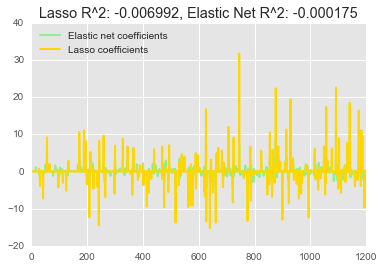

In [47]:


enet = ElasticNet(alpha=0.1, l1_ratio=0.7)


y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

plt.plot(enet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(lasso.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
#plt.plot(coef, '--', color='navy', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

**Conclussion**: even when carrying parameter tunning, none of the tested models (SVR, Lasso, Lasso + Elastic Net, GBR) were able to help us predicting the number of likes a picture has given it's 1200 sentiment descriptors.

## F2: "Previous activity"

Original data of instagram pictures loading

In [6]:
D_DIR = "../data/"
mcdonalds_icmr_clean = "mcdonalds/df_mc_20161011.pkl"
burgerking_icmr_clean = "burgerking/df_bk_20161011.pkl"
df_mc_ = pd.read_pickle(D_DIR + mcdonalds_icmr_clean) # dump csv into a Pandas DataFrame
df_bk_ = pd.read_pickle(D_DIR + burgerking_icmr_clean) # dump csv into a Pandas DataFrame

Transform categorical values to numerical ones

In [7]:
df_mc_.sample(3)

,instaGramId,imageDateCreated,imageTagCount,imageFilter,imageLikeCount,imageCommentCount,imageLink,imageCaption,imageUsersInImageCollection,imageTagCollection,imageLongitude,imageLatitude,userFullName,userProfileImage,userName,userId,followedByCount,followersCount,postedMedia,userBio,userPostedLikedImage,comments,googleLogo,googleFaceCount,googleText,googleLandMark,product,brand,googleLabel_list,googleLabelConfidence_list,googleLabel_dict,imageTagCollection_list,imageCaption_clean,famous_attribute,activity_attribute,sentiment_attribute_num,sentiment_attribute,imageDateCreated_str,weekend_attribute,filter_attribute,face_attribute,logo_attribute,food_attribute,conjoint_category
32621,1088375399517645413_285650377,1443964479,21,Normal,45,2,https://scontent.cdninstagram.com/hphotos-xat1/t51.2885-15/s640x640/sh0.08/e35/12145206_1204103622949049_242429976_n.jpg,Cissou présente le menu Porcard 🍔🍟🐷 #foodporn#hamburger#fries#mcdonalds#burgerking#paulbocuse#12000calories#tropbon#pétagedebide#marseille#jadore#repasdegrosporc#jevaispluspouvoirmelever#ballon...,[],"[""picoftheday"",""burgerking"",""marseille"",""fries"",""repasdegrosporc"",""love"",""hamburger"",""paulbocuse"",""foodporn"",""kiss"",""pétagedebide"",""jadore"",""follow"",""landscape"",""mcdonalds"",""bye"",""tropbon"",""voilav...",5.391963,43.278789,"""CypCyp, Cissou & Co. ©""",https://scontent.cdninstagram.com/hphotos-xat1/t51.2885-19/s150x150/12145080_1515832432062179_1799495094_a.jpg,"""cyp_jrd""",285650377,193,210,82,Blondard 👱🏻 - French student 🇫🇷 - 20 yo 🙊 - Lyon 🔴🔵 / Marseille 🎉 - Kedge BS 🎓 - Projet Yéga 🇨🇲 - Unis-Terre 🍃,False,"[""""Amaze balls!!"""",""""Mdr jtm trop jai envie de manger avec toi :(((""""]",[],0,2013,NaN,0,McDonalds,"[food, restaurant, fast food, veggie burger, dish, lunch, fast food restaurant, submarine sandwich, cheeseburger, hamburger]","[0.94692725, 0.65297788, 0.62065518, 0.60278773, 0.93073016, 0.87839568, 0.8213675, 0.72197992, 0.99657011, 0.96684694]","{u'hamburger': 0.96684694, u'restaurant': 0.65297788, u'food': 0.94692725, u'fast food restaurant': 0.8213675, u'cheeseburger': 0.99657011, u'lunch': 0.87839568, u'submarine sandwich': 0.72197992,...","[picoftheday, burgerking, marseille, fries, repasdegrosporc, love, hamburger, paulbocuse, foodporn, kiss, ptagedebide, jadore, follow, landscape, mcdonalds, bye, tropbon, voilavoila, jevaispluspou...","[cissou, pr, sente, le, menu, porcard, hamburger, fries, mcdonalds, burgerking, paulbocuse, calories, tropbon, tagedebide, marseille, jadore, repasdegrosporc, jevaispluspouvoirmelever, ballonn, la...",common,high,0.5,positive,2015-10-04 13:14:39,weekend yes,filter no,face no,logo no,food yes,0
27976,1092338980877307244_295320066,1444436975,4,Ludwig,10,0,https://scontent.cdninstagram.com/hphotos-xtp1/t51.2885-15/s640x640/sh0.08/e35/12142562_1627301184214475_35125120_n.jpg,"Está certo que o BK já faz isso, mas essa atitude do Mc foi genial! #mcdonalds #batatafrita #bacon #delicia",[],"[""delicia"",""batatafrita"",""mcdonalds"",""bacon""]",-46.695858,-23.516132,"""Kaká Monteiro""",https://scontent.cdninstagram.com/hphotos-xta1/t51.2885-19/11371054_1456874147952800_845748104_a.jpg,"""kakamonteiro86""",295320066,811,678,1573,NaN,False,[],[],0,NaN,NaN,0,McDonalds,"[dish, food, meal, pot roast, greek food, souvlaki, bolognese sauce, kebab, carne asada, french fries]","[0.97486621, 0.98984253, 0.69883442, 0.92650962, 0.56796205, 0.92771649, 0.6622048, 0.57831693, 0.64206058, 0.64270252]","{u'greek food': 0.56796205, u'pot roast': 0.92650962, u'bolognese sauce': 0.6622048, u'kebab': 0.57831693, u'food': 0.98984253, u'carne asada': 0.64206058, u'french fries': 0.64270252, u'souvlaki'...","[delicia, batatafrita, mcdonalds, bacon]","[est, certo, que, bk, faz, isso, mas, essa, atitude, mc, foi, genial, ]",famous,low,0.0,neutral,2015-10-10 00:29:35,weekend yes,filter yes,face no,logo no,food no,0
22519,1097342241476963240_1903059345,1445033410,7,Normal,6,0,https://scontent.cdninstagram.com/hphotos-xpt1/t51.288

In [59]:
# fit SVR with filter_attribute_num, face_attribute_num, logo_attribute_num, food_attribute_num, weekend_attribute_num,
# sentiment_attribute_num, likes_followed_ratio, brand_num, postedMedia, followersCount, followedByCount, imageTagCount
# PREDICT imageLikeCount
df_mc_["filter_attribute_num"] = df_mc_["filter_attribute"].map(lambda x: 0 if x == "filter no" else 1)
df_mc_["face_attribute_num"] = df_mc_["face_attribute"].map(lambda x: 0 if x == "face no" else 1)
df_mc_["logo_attribute_num"] = df_mc_["logo_attribute"].map(lambda x: 0 if x == "logo no" else 1)
df_mc_["food_attribute_num"] = df_mc_["food_attribute"].map(lambda x: 0 if x == "food no" else 1)
df_mc_["weekend_attribute_num"] = df_mc_["weekend_attribute"].map(lambda x: 0 if x == "weekend no" else 1)
df_mc_["brand_num"] = df_mc_["brand"].map(lambda x: 0 if x == "McDonalds" else 1)
df_mc_["userBio_length"] = df_mc_["userBio"].map(lambda x: len(str(x)))
df_mc_["imageTag_amount"] = df_mc_["imageTagCollection_list"].map(lambda x: len(filter(None, x)))
df_mc_["imageCaption_word_amount"] = df_mc_["imageCaption_clean"].map(lambda x: len(filter(None, x)))

df_bk_["filter_attribute_num"] = df_bk_["filter_attribute"].map(lambda x: 0 if x == "filter no" else 1)
df_bk_["face_attribute_num"] = df_bk_["face_attribute"].map(lambda x: 0 if x == "face no" else 1)
df_bk_["logo_attribute_num"] = df_bk_["logo_attribute"].map(lambda x: 0 if x == "logo no" else 1)
df_bk_["food_attribute_num"] = df_bk_["food_attribute"].map(lambda x: 0 if x == "food no" else 1)
df_bk_["weekend_attribute_num"] = df_bk_["weekend_attribute"].map(lambda x: 0 if x == "weekend no" else 1)
df_bk_["brand_num"] = df_bk_["brand"].map(lambda x: 0 if x == "McDonalds" else 1)
df_bk_["userBio_length"] = df_bk_["userBio"].map(lambda x: len(str(x)))
df_bk_["imageTag_amount"] = df_bk_["imageTagCollection_list"].map(lambda x: len(filter(None, x)))
df_bk_["imageCaption_word_amount"] = df_bk_["imageCaption_clean"].map(lambda x: len(filter(None, x)))

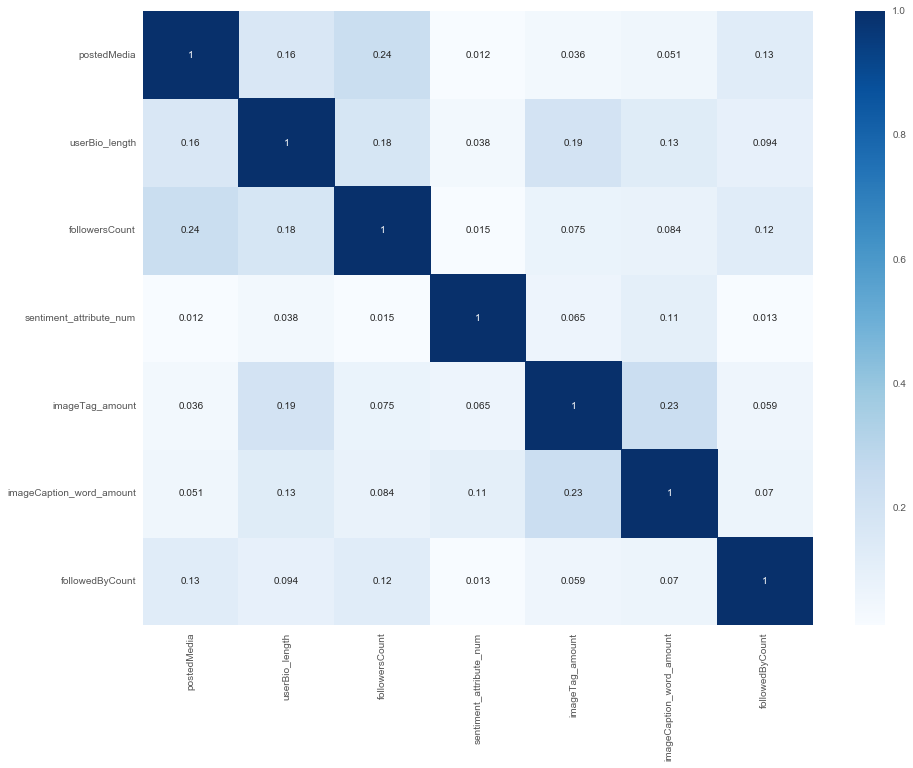

In [13]:
filter_col = [col for col in list(df_bk_) if col.endswith('nuam')]
filter_col.extend(["postedMedia", "userBio_length", "followersCount",
                   "sentiment_attribute_num", "imageTag_amount", "imageCaption_word_amount",
                   "followedByCount"])
correlationMatrix = df_bk_[filter_col].corr().abs()

plt.subplots(figsize=(15, 11))
sns.heatmap(correlationMatrix,annot=True, cmap="Blues")

# Mask unimportant features
sns.heatmap(correlationMatrix, mask=correlationMatrix < 1, cbar=False, cmap="Blues")

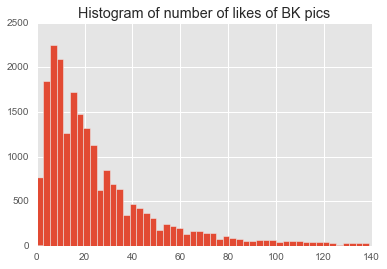

In [22]:
fig, ax = plt.subplots()
df_bk_[df_bk_["imageLikeCount"] < 140].imageLikeCount.hist(bins=50, ax=ax)
ax.set_xlim([0, 140])
ax.set_title("Histogram of number of likes of BK pics")

In [41]:
df_bk_["imageLikeCount"].quantile(0.666)

28.0

In [23]:
print(df_bk_["imageLikeCount"].mean()-27)
print(df_bk_["imageLikeCount"].mean())
print(df_bk_["imageLikeCount"].mean()+27)
print(df_bk_["imageLikeCount"].describe())

10.1032269728
37.1032269728
64.1032269728
count    22126.000000
mean        37.103227
std        125.636743
min          0.000000
25%          9.000000
50%         19.000000
75%         36.000000
max       9097.000000
Name: imageLikeCount, dtype: float64


In [54]:
print(df_bk_[df_bk_["imageLikeCount"] <= 12].instaGramId.count())
print(df_bk_[(df_bk_["imageLikeCount"] > 12) & (df_bk_["imageLikeCount"] <= 28)].instaGramId.count())
print(df_bk_[df_bk_["imageLikeCount"] > 28].instaGramId.count())

7580
7203
7343


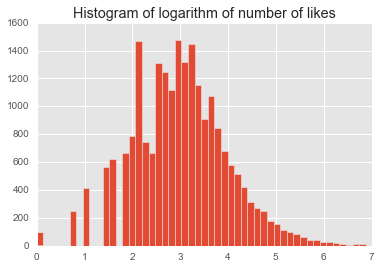

In [54]:
fig, ax = plt.subplots()
np.log1p(df_bk_[df_bk_["imageLikeCount"] < 1000].imageLikeCount).hist(bins=50, ax=ax)
ax.set_title("Histogram of logarithm of number of likes")
# would this be more useful now? As now it is a normal distribution

In [16]:
df_bk_.iloc[0:3]

,instaGramId,imageDateCreated,imageTagCount,imageFilter,imageLikeCount,imageCommentCount,imageLink,imageCaption,imageUsersInImageCollection,imageTagCollection,imageLongitude,imageLatitude,userFullName,userProfileImage,userName,userId,followedByCount,followersCount,postedMedia,userBio,userPostedLikedImage,comments,googleLogo,googleFaceCount,googleText,googleLandMark,product,brand,googleLabel_list,googleLabelConfidence_list,googleLabel_dict,imageTagCollection_list,imageCaption_clean,famous_attribute,activity_attribute,sentiment_attribute_num,sentiment_attribute,imageDateCreated_str,weekend_attribute,filter_attribute,face_attribute,logo_attribute,food_attribute,conjoint_category,filter_attribute_num,face_attribute_num,logo_attribute_num,food_attribute_num,weekend_attribute_num,brand_num,userBio_length,imageTag_amount,imageCaption_word_amount,imageLikeCount1
0,1165524631240624607_638926073,1453161384,7,Normal,1.386294,0,https://scontent.cdninstagram.com/hphotos-xpt1/t51.2885-15/s320x320/e35/12545400_131527523893372_2086774170_n.jpg,I will gladly pay you Tuesday for a hamburger today. #popeye #popeyethesailorman #wimpy #wimpysburgers #jackinthebox #mcdonalds #burgerking,[],"[""burgerking"",""popeyethesailorman"",""mcdonalds"",""wimpysburgers"",""jackinthebox"",""popeye"",""wimpy""]",-89.823100,37.913900,"""Lisa Qualls Rebman""",https://scontent.cdninstagram.com/hphotos-xaf1/t51.2885-19/s150x150/12276988_191716141166756_530478826_a.jpg,"""lisarebs""",638926073,132,268,1111,"Stay at home mom to 3 kids. Active in pregnancy & infant loss support. Dealing with a spinal disease, trying to live a happy life with minimal pain.",False,[],[],0,"""IT'S TUESDAY BITCH!!!\nWHERE'S OUR-\nFUCKING MONEY!!!""",NaN,0,BurgerKing,"[cartoon, comics, artwork]","[0.92367387, 0.67196417, 0.70198238]","{u'comics': 0.67196417, u'cartoon': 0.92367387, u'artwork': 0.70198238}","[burgerking, popeyethesailorman, mcdonalds, wimpysburgers, jackinthebox, popeye, wimpy]","[i, gladly, pay, tuesday, hamburger, today, ]",common,low,0.50,positive,2016-01-18 23:56:24,weekend no,filter no,face no,logo no,food no,0,0,0,0,0,0,1,148,7,6,3
1,1164403947432345237_188454382,1453027789,24,Normal,3.332205,2,https://scontent.cdninstagram.com/hphotos-xpf1/t51.2885-15/s480x480/e35/11931269_474852249364531_1430106759_n.jpg,"regram @animalrevenge\nMcDonalds, Arby's, Wendy's, Taco Bell, Burger King and all these nasty fast food chains that only serve crap to our children can go to hell!\n\nWe need more fresh markets! ...",[],"[""wendys"",""bk"",""m"",""pic"",""archdaily"",""mcdonalds"",""greenhouse"",""vegans"",""mcshit"",""govegan"",""gogreen"",""burgerking"",""tacobell"",""arbys"",""picoftheday"",""meatlessmonday"",""freshmarket"",""nongmo"",""meatismur...",-73.591152,40.709365,Angele Lbn,https://scontent.cdninstagram.com/hphotos-xpa1/t51.2885-19/s150x150/12277478_956146861113938_31544961_a.jpg,ange_0,188454382,158,136,333,Angèle ; 19yo ; 🇫🇷\nIn love with animals 🐶🐱🐹🐰🐻🐼🐨🐔🐧🐴🐝🐛🐌🐞🐍🐢 i'm also a vegetarian 🌻🌍🌏🌎,False,"[""""Yes!"""",""""Ahhh!""""]",[],0,"""icDonald\nWE NEED LESS OF THESE\nAND MORE OF THESE\nMIND""",NaN,0,BurgerKing,"[amusement park, toy, fair, park]","[0.78556997, 0.62020761, 0.57394826, 0.52019644]","{u'toy': 0.62020761, u'park': 0.52019644, u'fair': 0.57394826, u'amusement park': 0.78556997}","[wendys, bk, m, pic, archdaily, mcdonalds, greenhouse, vegans, mcshit, govegan, gogreen, burgerking, tacobell, arbys, picoftheday, meatlessmonday, freshmarket, nongmo, meatismurder, vegansofig, mc...","[regram, mcdonalds, arby, wendy, taco, bell, burger, king, nasty, fast, food, chains, serve, crap, children, go, hell, need, fresh, markets, organic, gardens, greenhouses, follow, imagine, could, ...",common,high,-0.22,negative,2016-01-17 10:49:49,weekend yes,filter no,face no,logo no,food no,0,0,0,0,0,1,1,150,24,38,27
2,1164092983056274899_1252201540,1452990719,20,Normal,4.189655,2,https://scontent.cdninstagram.com/hphotos-xaf1/t51.2885-15/s480x480/e35/12479444_1127394633951162_12382

### GBR

In [86]:
column_names_f2 = ["instaGramId",
                    "postedMedia", "userBio_length", "followersCount",
                    "imageLikeCount"]
train, test = train_test_split(df_bk_[column_names_f2], train_size = 0.5)
train.set_index("instaGramId", inplace=True)
test.set_index("instaGramId", inplace=True)
column_names_f2.remove("instaGramId")
X_train = train.drop("imageLikeCount", 1)
y_train = train["imageLikeCount"]
X_test = test.drop("imageLikeCount", 1)
y_test = test["imageLikeCount"]
tuned_parameters2_gbr = [{'n_estimators': [300, 200, 80, 50], 'max_depth': [1, 2, 3, 4, 6],
                      'learning_rate': [1e-2, 1e-1]},
                   ]

grid2_gbr = GridSearchCV(estimator=GradientBoostingRegressor(verbose=False), param_grid=tuned_parameters2_gbr)
grid2_gbr = grid2_gbr.fit(X_train, y_train)
grid2_gbr.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0,
             verbose=False, warm_start=False)

In [82]:
est = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=1, random_state=0,
                                loss='ls')
eval_model(df_bk_, column_names_f4, est)

('Fitting of the model took', '0.100000143051', 'seconds')
Distribution of importances of variables, sum is 1:
[('followersCount', 0.47999999999999998), ('userBio_length', 0.29999999999999999), ('postedMedia', 0.22)]
Mean absolute error is: 32.05	
Mean squared error is: 18054.67	
Median absolute error is: 20.48	
R^2 score:	0.0118	
[(18, 32.064498211804931), (17, 58.481653297933761), (7, 29.115294099332335), (59, 29.115294099332335), (11, 35.596697615698048), (16, 32.064498211804931), (230, 49.907283507942438), (23, 34.041876721866856), (27, 23.257855024894084), (62, 39.457601248247443), (147, 29.115294099332335), (208, 29.115294099332335), (28, 29.942110697466994), (5, 32.064498211804931), (25, 32.064498211804931)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.27075929952798139, pvalue=3.771608871564608e-185))
('Spearman rank-order (correlation, p-value):', (0.10901348556131001, 1.3327834312340253e-30))


### SVR

In [87]:
svr_f2 = SVR(C=100, gamma=0.1, kernel="rbf")
eval_model(df_bk_, column_names_f2, svr_f2)

('Fitting of the model took', '79.5', 'seconds')
Mean absolute error is: 28.53	
Mean squared error is: 21044.76	
Median absolute error is: 15.90	
R^2 score:	0.0070	
[(32, 42.899962118140131), (21, 29.676172602577356), (71, 29.676172602577804), (19, 29.367605442910182), (580, 29.676172602577804), (6, 9.8999731081483553), (35, 29.676172602577804), (28, 29.676172602577804), (60, 29.676170285009139), (15, 29.676172602577804), (32, 32.099919919242119), (9, 9.2423765514745782), (1, 29.676172602577804), (44, 29.676172602577804), (13, 29.676172602577804)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.2197566138805965, pvalue=4.4637293803803462e-121))
('Spearman rank-order (correlation, p-value):', (0.1060577950569922, 4.7996701385371356e-29))


### Lasso

In [135]:
column_names_f2 = ["instaGramId",
                    "postedMedia", "userBio_length", "followersCount",
                    "imageLikeCount"]
train, test = train_test_split(df_bk_[column_names_f2], train_size = 0.5)
train.set_index("instaGramId", inplace=True)
test.set_index("instaGramId", inplace=True)
column_names_f2.remove("instaGramId")
X_train = train.drop("imageLikeCount", 1)
y_train = train["imageLikeCount"]
X_test = test.drop("imageLikeCount", 1)
y_test = test["imageLikeCount"]
tuned_parameters2_lasso = [{'alpha': [0.9, 0.5, 0.3, 0.1, 1],
                            'tol': [1, 0.01, 0.001, 0.000001, 0.000000001],
                           #'learning_rate':[0.01, 0.001]
                           }]

grid2_lasso = GridSearchCV(estimator=linear_model.Lasso(), param_grid=tuned_parameters2_lasso)
grid2_lasso = grid2_lasso.fit(X_train, y_train)
grid2_lasso.best_estimator_

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-09, warm_start=False)

In [136]:
lass_f2 = linear_model.Lasso(alpha = 1, tol=1e-09) 
eval_model(df_bk_, column_names_f2, lass_f2)

('Fitting of the model took', '0.00300002098083', 'seconds')
Mean absolute error is: 32.29	
Mean squared error is: 17277.84	
Median absolute error is: 20.50	
R^2 score:	0.0128	
[(29, 52.76808711688831), (36, 23.311129916038023), (7, 23.137500399304617), (41, 41.632575319645611), (26, 29.99166203595648), (44, 41.03943478963172), (12, 28.927819724688135), (14, 29.192258053453564), (42, 30.626726907775399), (60, 110.19083854032348), (59, 22.067625514832244), (74, 28.363869064202127), (10, 44.917212503524624), (34, 44.509045729043748), (4, 25.534648358129431)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.24468415895746978, pvalue=1.6058115676771131e-150))
('Spearman rank-order (correlation, p-value):', (0.1134819019238302, 4.8942231894223949e-33))


### Elastic-net

In [138]:
column_names_f2 = ["instaGramId",
                    "postedMedia", "userBio_length", "followersCount",
                    "imageLikeCount"]
train, test = train_test_split(df_bk_[column_names_f2], train_size = 0.5)
train.set_index("instaGramId", inplace=True)
test.set_index("instaGramId", inplace=True)
column_names_f2.remove("instaGramId")
X_train = train.drop("imageLikeCount", 1)
y_train = train["imageLikeCount"]
X_test = test.drop("imageLikeCount", 1)
y_test = test["imageLikeCount"]
tuned_parameters2_enet = [{'alpha': [0.9, 0.5, 0.3, 0.1, 1],
                            'l1_ratio': [0.9, 0.7, 0.5, 0.4],
                           #'learning_rate':[0.01, 0.001]
                           }]

grid2_enet = GridSearchCV(estimator=linear_model.ElasticNet(), param_grid=tuned_parameters2_enet)
grid2_enet = grid2_enet.fit(X_train, y_train)
grid2_enet.best_estimator_

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [139]:
enet_f2 = ElasticNet(alpha=1, l1_ratio=0.9)
eval_model(df_bk_, column_names_f2, enet_f2)

('Fitting of the model took', '0.00300002098083', 'seconds')
Mean absolute error is: 31.79	
Mean squared error is: 9330.79	
Median absolute error is: 20.47	
R^2 score:	0.0205	
[(8, 33.995102659528136), (5, 24.878043455431992), (3, 29.355206393901042), (45, 24.500471576552961), (18, 25.275392357033631), (24, 56.099872840989562), (169, 54.735385079381054), (67, 27.131686859290696), (5, 21.8032096041015), (13, 30.635607294948439), (40, 24.060908929544979), (17, 37.020748885102691), (8, 25.674240244405368), (5, 27.541180774275578), (27, 26.421371952925703)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.24202703188673713, pvalue=3.252269311512161e-147))
('Spearman rank-order (correlation, p-value):', (0.14486505551576806, 5.9643755737053004e-53))


## F3: "Caption completition"

### GBR

In [140]:
column_names_f3 = ["instaGramId",
                    "sentiment_attribute_num", "imageTag_amount", "imageCaption_word_amount",
                    "imageLikeCount"]
train, test = train_test_split(df_bk_[column_names_f3], train_size = 0.5)
train.set_index("instaGramId", inplace=True)
test.set_index("instaGramId", inplace=True)
column_names_f3.remove("instaGramId")
X_train = train.drop("imageLikeCount", 1)
y_train = train["imageLikeCount"]
X_test = test.drop("imageLikeCount", 1)
y_test = test["imageLikeCount"]
tuned_parameters3_gbr = [{'n_estimators': [300, 200, 80, 50], 'max_depth': [1, 2, 3, 4, 6],
                      'learning_rate': [1e-2, 1e-1]},
                   ]

grid3_gbr = GridSearchCV(estimator=GradientBoostingRegressor(verbose=False), param_grid=tuned_parameters3_gbr)
grid3_gbr = grid3_gbr.fit(X_train, y_train)
grid3_gbr.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0,
             verbose=False, warm_start=False)

In [141]:
gbr_f3 = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=1, random_state=0,
                                loss='ls')
eval_model(df_bk_, column_names_f3, gbr_f3)

('Fitting of the model took', '0.287000179291', 'seconds')
Distribution of importances of variables, sum is 1:
[('imageTag_amount', 0.65500000000000003), ('imageCaption_word_amount', 0.255), ('sentiment_attribute_num', 0.089999999999999997)]
Mean absolute error is: 32.44	
Mean squared error is: 13280.83	
Median absolute error is: 22.07	
R^2 score:	0.0078	
[(6, 35.052384786732681), (17, 33.066866503457746), (17, 35.052384786732681), (3, 33.066866503457746), (189, 45.908017485785734), (69, 39.675616218856767), (4, 33.066866503457746), (20, 39.675616218856767), (22, 39.675616218856767), (10, 33.066866503457746), (7, 39.675616218856767), (17, 39.675616218856767), (41, 33.066866503457746), (11, 35.052384786732681), (10, 35.561335971550541)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.28439602302194494, pvalue=7.125879047543487e-205))
('Spearman rank-order (correlation, p-value):', (0.088932464990689672, 7.1506629183213126e-21))


### SVR

In [142]:
svr_f3 = SVR(C=100, gamma=0.1, kernel="rbf")
eval_model(df_bk_, column_names_f3, svr_f3)

('Fitting of the model took', '13.1390001774', 'seconds')
Mean absolute error is: 26.13	
Mean squared error is: 13910.63	
Median absolute error is: 9.92	
R^2 score:	-0.0053	
[(51, 15.852640128225502), (3, 13.36998546606506), (128, 28.22968776097003), (54, 18.099488995189915), (9, 14.476173240683757), (52, 13.844097305867535), (12, 20.899918913753993), (26, 10.89979475121104), (13, 10.899984792076651), (5, 18.099488995189915), (275, 24.900033439937417), (22, 23.093060313038787), (24, 13.899568110817349), (6, 18.099488995189915), (23, 15.90538804509174)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.33188121715661567, pvalue=1.1706697300226011e-282))
('Spearman rank-order (correlation, p-value):', (0.13209289322860746, 3.0061107603833683e-44))


### Lasso

In [154]:
column_names_f3 = ["instaGramId",
                    "sentiment_attribute_num", "imageTag_amount", "imageCaption_word_amount",
                    "imageLikeCount"]
train, test = train_test_split(df_bk_[column_names_f3], train_size = 0.5)
train.set_index("instaGramId", inplace=True)
test.set_index("instaGramId", inplace=True)
column_names_f3.remove("instaGramId")
X_train = train.drop("imageLikeCount", 1)
y_train = train["imageLikeCount"]
X_test = test.drop("imageLikeCount", 1)
y_test = test["imageLikeCount"]
tuned_parameters3_lasso = [{'alpha': [0.9, 0.5, 0.3, 0.1, 1],
                            'tol': [1, 0.01, 0.001, 0.000001, 0.000000001],
                           #'learning_rate':[0.01, 0.001]
                           }]

grid3_lasso = GridSearchCV(estimator=linear_model.Lasso(), param_grid=tuned_parameters3_lasso)
grid3_lasso = grid3_lasso.fit(X_train, y_train)
grid3_lasso.best_estimator_

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-09, warm_start=False)

In [155]:
lass_f3 = linear_model.Lasso(alpha = 0.5, tol=1e-09) 
eval_model(df_bk_, column_names_f3, lass_f3)

('Fitting of the model took', '0.00200009346008', 'seconds')
Mean absolute error is: 33.06	
Mean squared error is: 23245.61	
Median absolute error is: 20.45	
R^2 score:	0.0053	
[(15, 30.451888193474865), (4, 28.76357562121072), (53, 52.682844811556507), (33, 23.679476809187687), (7, 28.125668132804016), (6, 26.005696869858536), (24, 24.317384297594391), (16, 33.416015742552418), (8, 38.087616959124716), (157, 79.41747603894629), (48, 49.944127155434927), (2, 29.833141800298762), (16, 32.365610658694976), (35, 61.3689786610638), (42, 31.953113063244242)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.26288083905327159, pvalue=2.8947381167173087e-174))
('Spearman rank-order (correlation, p-value):', (0.074979573337956074, 2.8652912279585611e-15))


### Elastic-net

In [149]:
column_names_f3 = ["instaGramId",
                    "sentiment_attribute_num", "imageTag_amount", "imageCaption_word_amount",
                    "imageLikeCount"]
train, test = train_test_split(df_bk_[column_names_f3], train_size = 0.5)
train.set_index("instaGramId", inplace=True)
test.set_index("instaGramId", inplace=True)
column_names_f3.remove("instaGramId")
X_train = train.drop("imageLikeCount", 1)
y_train = train["imageLikeCount"]
X_test = test.drop("imageLikeCount", 1)
y_test = test["imageLikeCount"]
tuned_parameters3_enet = [{'alpha': [0.9, 0.5, 0.3, 0.1, 1],
                            'l1_ratio': [0.9, 0.7, 0.5, 0.4],
                           #'learning_rate':[0.01, 0.001]
                           }]

grid3_enet = GridSearchCV(estimator=linear_model.ElasticNet(), param_grid=tuned_parameters3_enet)
grid3_enet = grid3_enet.fit(X_train, y_train)
grid3_enet.best_estimator_

ElasticNet(alpha=0.5, copy_X=True, fit_intercept=True, l1_ratio=0.4,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [150]:
enet_f3 = ElasticNet(alpha=0.5, l1_ratio=0.4)
eval_model(df_bk_, column_names_f3, enet_f3)

('Fitting of the model took', '0.00300002098083', 'seconds')
Mean absolute error is: 32.92	
Mean squared error is: 22650.10	
Median absolute error is: 21.09	
R^2 score:	0.0085	
[(30, 33.416680688137987), (38, 34.164643571548851), (74, 25.791552733475442), (16, 41.31537945736315), (6, 35.186177269522325), (5, 27.992750819038466), (31, 29.74090211808802), (12, 40.293845759389676), (4, 30.330734311882797), (21, 55.954457890558686), (44, 63.831811377449057), (90, 25.791552733475442), (5, 26.676301024167607), (43, 63.24197918365428), (22, 46.876094733743969)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.29345313376033677, pvalue=1.3288314678467152e-218))
('Spearman rank-order (correlation, p-value):', (0.096800199613736662, 1.8960216192982489e-24))


## F4: "Number of followers"

### GBR

In [158]:
column_names_f4 = ["instaGramId",
                    "followedByCount",
                    "imageLikeCount"]
train, test = train_test_split(df_bk_[column_names_f4], train_size = 0.5)
train.set_index("instaGramId", inplace=True)
test.set_index("instaGramId", inplace=True)
column_names_f4.remove("instaGramId")
X_train = train.drop("imageLikeCount", 1)
y_train = train["imageLikeCount"]
X_test = test.drop("imageLikeCount", 1)
y_test = test["imageLikeCount"]
tuned_parameters4_gbr = [{'n_estimators': [300, 200, 80, 50], 'max_depth': [1, 2, 3, 4, 6],
                      'learning_rate': [1e-2, 1e-1]},
                   ]

grid4_gbr = GridSearchCV(estimator=GradientBoostingRegressor(verbose=False), param_grid=tuned_parameters4_gbr)
grid4_gbr = grid4_gbr.fit(X_train, y_train)
grid4_gbr.best_params_

{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 300}

In [152]:
gbr_f4 = GradientBoostingRegressor(n_estimators=300, learning_rate=0.01, max_depth=1, random_state=0,
                                loss='ls')
eval_model(df_bk_, column_names_f4, gbr_f4)

('Fitting of the model took', '0.363999843597', 'seconds')
Distribution of importances of variables, sum is 1:
[('followedByCount', 1.0)]
Mean absolute error is: 27.76	
Mean squared error is: 15558.74	
Median absolute error is: 17.64	
R^2 score:	0.2818	
[(9, 28.639489297975437), (23, 28.639489297975437), (13, 28.639489297975437), (5, 28.639489297975437), (4, 28.639489297975437), (103, 40.448173813515595), (109, 30.865722401350954), (56, 112.88224991619805), (19, 28.639489297975437), (75, 28.639489297975437), (6, 28.639489297975437), (9, 28.639489297975437), (15, 28.639489297975437), (6, 28.639489297975437), (47, 28.639489297975437)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.44013504242464241, pvalue=0.0))
('Spearman rank-order (correlation, p-value):', (0.60264158126951661, 0.0))


### SVR

In [153]:
svr_f4 = SVR(C=100, gamma=0.1, kernel="rbf")
eval_model(df_bk_, column_names_f4, svr_f4)

('Fitting of the model took', '20.2999999523', 'seconds')
Mean absolute error is: 23.63	
Mean squared error is: 15704.89	
Median absolute error is: 9.88	
R^2 score:	0.0675	
[(4, 13.24636973953676), (23, 18.89997198806519), (8, 8.8662658611215051), (6, 17.766182658330166), (38, 21.686289233670635), (25, 10.836755627817041), (12, 10.100395908125691), (8, 12.631347820965601), (218, 20.099548132097368), (10, 9.0996947179526728), (8, 7.3227760479185946), (7, 11.530928155218248), (5, 18.505686731285572), (20, 25.90016822464456), (15, 8.6953174822576074)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.52128611236490374, pvalue=0.0))
('Spearman rank-order (correlation, p-value):', (0.29585793193274051, 2.4685192883980542e-222))


### Lasso

In [159]:
column_names_f4 = ["instaGramId",
                    "followedByCount",
                    "imageLikeCount"]
train, test = train_test_split(df_bk_[column_names_f4], train_size = 0.5)
train.set_index("instaGramId", inplace=True)
test.set_index("instaGramId", inplace=True)
column_names_f4.remove("instaGramId")
X_train = train.drop("imageLikeCount", 1)
y_train = train["imageLikeCount"]
X_test = test.drop("imageLikeCount", 1)
y_test = test["imageLikeCount"]
tuned_parameters4_lasso = [{'alpha': [0.9, 0.5, 0.3, 0.1, 1],
                            'tol': [1, 0.01, 0.001, 0.000001, 0.000000001],
                           #'learning_rate':[0.01, 0.001]
                           }]

grid4_lasso = GridSearchCV(estimator=linear_model.Lasso(), param_grid=tuned_parameters4_lasso)
grid4_lasso = grid4_lasso.fit(X_train, y_train)
grid4_lasso.best_estimator_

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1, warm_start=False)

In [161]:
lass_f4 = linear_model.Lasso(alpha = 1, tol=1) 
eval_model(df_bk_, column_names_f4, lass_f4)

('Fitting of the model took', '0.00200009346008', 'seconds')
Mean absolute error is: 25.31	
Mean squared error is: 8921.14	
Median absolute error is: 15.15	
R^2 score:	0.2206	
[(18, 25.189639732032457), (31, 34.702393858126392), (14, 23.070461832655095), (18, 28.61171959917516), (46, 36.099481510308507), (79, 33.854722698375447), (14, 27.826838895702064), (12, 31.766940027137011), (18, 29.098345635328478), (50, 28.062303106743993), (228, 49.379663013073305), (47, 27.87393173791045), (3, 24.028016290892275), (10, 25.0483612054073), (14, 26.366960787242103)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.55513421213183234, pvalue=0.0))
('Spearman rank-order (correlation, p-value):', (0.47767619651542736, 0.0))


### Elasticnet

In [162]:
column_names_f4 = ["instaGramId",
                    "followedByCount",
                    "imageLikeCount"]
train, test = train_test_split(df_bk_[column_names_f4], train_size = 0.5)
train.set_index("instaGramId", inplace=True)
test.set_index("instaGramId", inplace=True)
column_names_f4.remove("instaGramId")
X_train = train.drop("imageLikeCount", 1)
y_train = train["imageLikeCount"]
X_test = test.drop("imageLikeCount", 1)
y_test = test["imageLikeCount"]
tuned_parameters4_enet = [{'alpha': [0.9, 0.5, 0.3, 0.1, 1],
                            'l1_ratio': [0.9, 0.7, 0.5, 0.4],
                           #'learning_rate':[0.01, 0.001]
                           }]

grid4_enet = GridSearchCV(estimator=linear_model.ElasticNet(), param_grid=tuned_parameters4_enet)
grid4_enet = grid4_enet.fit(X_train, y_train)
grid4_enet.best_estimator_

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [163]:
enet_f4 = ElasticNet(alpha=1, l1_ratio=0.9)
eval_model(df_bk_, column_names_f4, enet_f4)

('Fitting of the model took', '0.00200009346008', 'seconds')
Mean absolute error is: 25.48	
Mean squared error is: 7447.52	
Median absolute error is: 14.83	
R^2 score:	0.1918	
[(18, 34.332587017129676), (8, 23.119618024585328), (14, 23.469476651497789), (5, 24.676488914345779), (4, 27.492850860991084), (10, 22.734773534981624), (32, 32.758223196023607), (38, 29.417073309009613), (36, 28.280032771544118), (68, 35.452134623249549), (15, 34.070193046945334), (21, 22.070042143847949), (82, 38.635848128152936), (14, 22.314943182686672), (0, 21.930098693082964)]
('Pearson correlation (correlation, p-value):', SpearmanrResult(correlation=0.56044538187413206, pvalue=0.0))
('Spearman rank-order (correlation, p-value):', (0.53412359079629668, 0.0))


**Conclussion:** using Instagram, fast-foods companies such as McDonalds and Burger King should target their clients (the ones profiled using the conjoin analysis, see other notebook) through Instagram users with as many followers as possible. 

### *Bonus.* Random Forest Classification

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [61]:
df_bk_["imageLikeCount_cat"] = df_bk_['imageLikeCount'].map(lambda x: "few" if int(x) <= 12 else "average" if float(x) <= 28 else "many")

In [62]:
column_names_rf = ["instaGramId",
                    "sentiment_attribute_num", "imageTag_amount", "imageCaption_word_amount",
                   "followedByCount",
                    "imageLikeCount_cat"]
train, test = train_test_split(df_bk_[column_names_rf], train_size = 0.5)
train.set_index("instaGramId", inplace=True)
test.set_index("instaGramId", inplace=True)
column_names_rf.remove("instaGramId")
X_train = train.drop("imageLikeCount_cat", 1)
y_train = train["imageLikeCount_cat"]
X_test = test.drop("imageLikeCount_cat", 1)
y_test = test["imageLikeCount_cat"]
tuned_parameters_rf = [{'n_estimators': [1,10, 50,100,200],
                        'min_samples_leaf': [1,10,40,60,100]
                           #'learning_rate':[0.01, 0.001]
                           }]

Parameter tunning

In [202]:
grid_rf = GridSearchCV(estimator=RandomForestClassifier(verbose=True), param_grid=tuned_parameters_rf, n_jobs=2)
grid_rf = grid_rf.fit(X_train, y_train)
grid_rf.best_estimator_

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=60,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=True, warm_start=False)

In [207]:
X_train[0:3]

,sentiment_attribute_num,imageTag_amount,imageCaption_word_amount,followedByCount
instaGramId,,,,
1136809137502412304_2250329086,0,5,0,246
1088392199551089258_9325797,0,19,1,492
1105087325699239607_1405446466,0,8,0,611


In [63]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=60)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=60,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [64]:
from sklearn import preprocessing

In [65]:
le = preprocessing.LabelEncoder()
le.fit(y_test)
y_test_num = le.transform(y_test)
y_pred_num = le.transform(rf.predict(X_test))

In [66]:
print("Percentage of future importances:")
print(zip(column_names_rf[0:4], rf.feature_importances_*100))
print(str(round(100*accuracy_score(y_test_num, y_pred_num),2))+ "% accuracy")

Percentage of future importances:
[('sentiment_attribute_num', 0.41075552478203969), ('imageTag_amount', 25.248779917144976), ('imageCaption_word_amount', 5.9685019971265278), ('followedByCount', 68.371962560946415)]
57.06% accuracy


In [284]:
# manually check, same as doing:
#tot = 0
#acc = 0
#for a in zip(y_test_num, y_pred_num):
#    tot += 1
#    if a[0] == a[1]:
#        acc +=1
#print(str(round(100*float(acc)/float(tot),2)) + "% accuracy")

We get a ~60% accuracy when using post completition data of the post in a 3 class classifier (33% accuracy expected if randomly pedicted the class)

### Random Forest Classifier with historical info of user + post completition

In [67]:
column_names_rf = ["instaGramId",
                    "postedMedia", "userBio_length", "followersCount",
                   "sentiment_attribute_num", "imageTag_amount", "imageCaption_word_amount",
                   "followedByCount",
                    "imageLikeCount_cat"]
train, test = train_test_split(df_bk_[column_names_rf], train_size = 0.5)
train.set_index("instaGramId", inplace=True)
test.set_index("instaGramId", inplace=True)
column_names_rf.remove("instaGramId")
X_train = train.drop("imageLikeCount_cat", 1)
y_train = train["imageLikeCount_cat"]
X_test = test.drop("imageLikeCount_cat", 1)
y_test = test["imageLikeCount_cat"]
tuned_parameters_rf = [{'n_estimators': [1,10, 50,100,200],
                        'min_samples_leaf': [1,10,40,60,100]
                           #'learning_rate':[0.01, 0.001]
                           }]

grid_rf = GridSearchCV(estimator=RandomForestClassifier(verbose=True), param_grid=tuned_parameters_rf, n_jobs=2)

Parameter tunning

In [267]:
grid_rf = grid_rf.fit(X_train, y_train)
grid_rf.best_estimator_

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=True, warm_start=False)

In [68]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [69]:
le = preprocessing.LabelEncoder()
le.fit(y_test)
y_test_num = le.transform(y_test)
y_pred_num = le.transform(rf.predict(X_test))

In [70]:
print("Percentage of future importances:")
print(zip(column_names_rf[0:11], rf.feature_importances_*100))
print("Accuracy:")
print(str(round(100*accuracy_score(y_test_num, y_pred_num),2))+ "%")

Percentage of future importances:
[('postedMedia', 16.644806959480405), ('userBio_length', 12.770870583101479), ('followersCount', 16.786739902828689), ('sentiment_attribute_num', 3.7049895641018469), ('imageTag_amount', 12.844999118708767), ('imageCaption_word_amount', 8.2497874909450726), ('followedByCount', 28.99780638083374)]
Accuracy:
59.65%


The model improves slightly more (+~0.4% accuracy) when adding historical information about the user posting the pic